In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

from params import *
from custom_layers import *

In [6]:
import load_script

In [7]:
%load_ext autoreload
%autoreload 2

# Loading the dataset

In [8]:
train_dataset,target=load_script.load_dataset(train=True)

In [9]:
test_dataset,test_target=load_script.load_dataset(train=False)

In [10]:
target=target.long()
test_target=test_target.long()

# Normalization

In [11]:
train_dataset.mean(0)

Variable containing:
 7.3101e+01  7.3109e+01  7.2001e+01  ...   6.4324e+01  6.5037e+01  6.5048e+01
 5.0706e+00  5.9728e+00  4.1829e+00  ...  -3.1212e+00 -2.7500e+00 -2.3117e+00
 5.3022e+01  5.3706e+01  5.2293e+01  ...   4.5319e+01  4.5553e+01  4.6292e+01
                ...                   ⋱                   ...                
 1.3597e+01  1.3734e+01  1.3298e+01  ...   1.0306e+01  1.0556e+01  1.0504e+01
 2.3973e+01  2.3983e+01  2.2980e+01  ...   2.2531e+01  2.2226e+01  2.2265e+01
 9.5851e+00  9.5892e+00  8.4953e+00  ...   8.9079e+00  9.0392e+00  8.8203e+00
[torch.FloatTensor of size 28x50]

In [12]:
train_dataset.shape

torch.Size([316, 28, 50])

In [13]:
mean=train_dataset.mean(0).view(1,28,-1)
std=train_dataset.std(0).view(1,28,-1)

In [14]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

In [16]:
class ThreeLayers(nn.Module):
    
    num_my_conv_layers=3
    num_linear_layers=2
    
    def __init__(self,params):
        super(ThreeLayers,self).__init__()
        
        self.params=params
        
        layers=[]
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        a=[*self.params[self.num_my_conv_layers]]
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

In [17]:
class Train:
    ''' Class to train a network
    
    Usage example:
    net_type=ThreeLayers
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(linear_filters=[200,2])
    optimizer_params=OptimizerParams()
    train_params=TrainParams(max_epoch=400)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params,)

    train=Train()
    train(params)
    
    '''
    
    def __init__(self):
        pass
        
    def __call__(self,params,repetitions=5):
        epochs=[]
        errors_max=[]
        errors_mean=[]
        for i in range(repetitions):
            for param in params.network.parameters():
                param.data.normal_(0, params.train_params.weights_initialization)
            print('Repetition',i)
            epoch,error_max,error_mean=self.train_test_network(params)
            epochs.append(epoch)
            errors_max.append(error_max)
            errors_mean.append(error_mean)
        
        return epochs,errors_max,errors_mean
    
    
    def train_test_network(self,params):
    
        errors_train=[]
        errors_test=[]
        
        
        for epoch in tqdm(range(params.train_params.max_epoch)):
            
            total_loss,output_train,error_train=self.train_epoch(params)
            output_test,error_test=self.test_epoch(params)
        
        
            errors_train.append(error_train)
            errors_test.append(error_test)
            
            if epoch%10==0 and params.verbose:
                print('Epoch:',epoch,'Loss:',total_loss,'Correct:',str(error_train*100)[:5]+"%",
                     'Correct test:',str(error_test*100)[:5]+"%")
                
        if params.plot:
            
            print('Performance:',np.mean(errors_test[300:]))
            plt.plot(list(range(epoch+1)),errors_train,label='Errors train')
            plt.plot(list(range(epoch+1)) ,errors_test,label='Errors test')
            
            plt.legend()
            plt.show()
                 
        return epoch,np.max(errors_test),np.mean(errors_test[300:])
    
    
    
    def train_epoch(self,params):
        
        # Set training True
        params.network.train(True)
        
        # Randomize training dataset
        if params.train_params.randomize_training_dataset:
            random_permutation=torch.randperm(train_dataset.shape[0])
        else:
            random_permutation=torch.arange(train_dataset.shape[0])

        train_dataset_shuffled=train_dataset[random_permutation]
        target_shuffled=target[random_permutation]
        
        
        # Iterate on the dataset
        total_loss=0
        output_target=torch.zeros(target_shuffled.shape[0])
        for b in range(0,train_dataset_shuffled.shape[0],params.train_params.mini_batch_size):

            train_element=train_dataset_shuffled.narrow(0,b,params.train_params.mini_batch_size)
            target_element=target_shuffled.narrow(0,b,params.train_params.mini_batch_size)

            params.optimizer.zero_grad()

            out=params.network(train_element)
            output_target[b:b+params.train_params.mini_batch_size]=(out[:,1]>out[:,0]).data

            loss=params.criterion(out,target_element)
            loss.backward()
            params.optimizer.step()
            total_loss+=loss.data[0]
            
        error_train=np.sum(list(output_target.long()==target_shuffled.data))/target.shape[0]    
        
        return total_loss,output_target,error_train
    
    def test_epoch(self,params):
        params.network.train(False)
        output_test=torch.zeros(test_target.shape[0])
        out=params.network.forward(test_dataset)
        output_test=(out[:,1]>out[:,0]).data.long()
        error_test=np.sum(list(output_test==test_target.data))/test_target.shape[0]
        
        return output_test,error_test

  0%|          | 1/400 [00:00<00:58,  6.80it/s]

28
Repetition 0


100%|██████████| 400/400 [00:39<00:00, 10.03it/s]

Performance: 0.7869


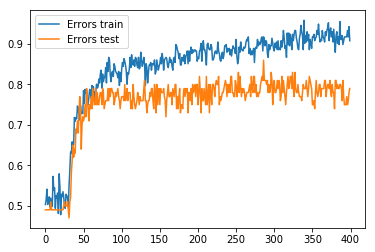

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:44<00:00,  8.90it/s]


Performance: 0.8135


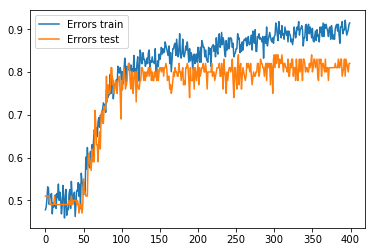

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:42<00:00,  9.44it/s]


Performance: 0.8041


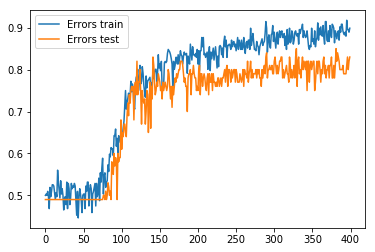

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


 90%|█████████ | 360/400 [00:44<00:04,  8.03it/s]

KeyboardInterrupt: 

In [18]:
net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(linear_filters=[200,2])
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=400)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

train=Train()
train(params)